# Regression

### Importing data

In [1]:
# Importing the libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [2]:

# Importing the dataset
df = pd.read_csv('br_prep1.csv', sep=';')
df

,X1,X3,X5,X6,X8,X9,X10,X12,X13,Y
0,0,0,0,659,1092.0,0,0,0,1,13884.0
1,1,0,1,1518,348.0,0,0,1,1,11700.0
2,2,0,0,476,504.0,0,0,1,1,6786.0
3,3,0,0,1310,418.0,0,0,1,1,12948.0
4,4,1,2,2029,108.0,0,0,0,0,11427.0
...,...,...,...,...,...,...,...,...,...,...
64,49,0,2,6884,337.0,0,0,0,0,9399.0
65,8,0,13,4721,668.0,0,1,0,0,14079.0
66,50,0,0,3286,295.0,0,0,0,0,11427.0
67,51,1,7,3963,0.0,0,1,0,0,13338.0


# Splitting

In [3]:
# Splitting the dataset into the Training set and Test set
X = df.iloc[:, :-1]
y = df['Y']
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10)

In [4]:
#!pip install statsmodels

# Multiple Linear Regression

In [5]:
from sklearn.linear_model import LinearRegression
# Fitting Multiple Regression
mr = LinearRegression().fit(X_train, y_train)

# Coefficient of determination R^2
mr.score(X_train, y_train).round(3)

0.321

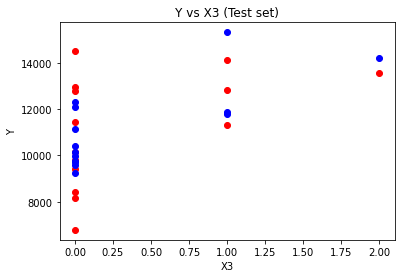

In [6]:
# Visualising the Test set results
plt.scatter(X_test['X3'], y_test, color = 'red')
plt.plot(X_test['X3'], mr.predict(X_test), 'bo')
plt.title('Y vs X3 (Test set)')
plt.xlabel('X3')
plt.ylabel('Y')
plt.show()

# R2 = 0,321. Получено низкое качество модели.

In [7]:
# Checking p-values
import statsmodels.api as sm
X1 = sm.add_constant(X_train)
mr1 = sm.OLS(y_train, X1).fit()
#mr1.pvalues
mr1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      Y   R-squared:                       0.321
Model:                            OLS   Adj. R-squared:                  0.186
Method:                 Least Squares   F-statistic:                     2.369
Date:                Wed, 27 Oct 2021   Prob (F-statistic):             0.0275
Time:                        11:23:25   Log-Likelihood:                -493.78
No. Observations:                  55   AIC:                             1008.
Df Residuals:                      45   BIC:                             1028.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        1.09e+04    904.321     12.051      0.000    9076.785    1.27e+04
X1           -22.5054     21.307     -1.056      0.296     -65.420      20.409
X3          1339.9528    654.811      2.046      0.047      21.095    2658.810
X5           -19.9111     77.125     -0.258      0.797    -175.248     135.426
X6            -0.0654      0.153     -0.427      0.672      -0.374       0.243
X8             1.4840      0.743      1.997      0.052      -0.013       2.981
X9            63.7717   1282.445      0.050      0.961   -2519.205    2646.749
X10          897.8734    828.831      1.083      0.284    -771.477    2567.224
X12         1519.7358   1200.135      1.266      0.212    -897.460    3936.932
X13         -794.7159    625.786     -1.270      0.211   -2055.114     465.682
==============================================================================
Omnibus:                       44.936   Durbin-Watson:                   2.236
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              212.247
Skew:                          -2.110   Prob(JB):                     8.15e-47
Kurtosis:                      11.649   Cond. No.                     2.46e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.46e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Количество значимых переменных - 6.

# Recursive feature elimination

In [8]:
# Feature ranking with recursive feature elimination
from sklearn.feature_selection import RFE
n_features = X.shape[1]
estimator = LinearRegression()
selector = RFE(estimator, n_features_to_select = 6)
selector = selector.fit(X, y)

# Selected Features
selected_columns=[]
for i in range(n_features):
    if selector.support_[i] == True:
        selected_columns.append(i)
        
f_lm = []
for column in selected_columns:
    f_lm.append(X.columns[column])

In [9]:
# Fitting Optimized Multiple Regression
mr_rfe = LinearRegression().fit(X_train[f_lm], y_train)

# Getting parameters
mr_rfe.coef_, mr_rfe.intercept_

(array([ -32.39194526, 1820.79155379,  423.69246665,  508.18842014,
        1443.46698014, -715.61383325]),
 11227.84640877538)

In [10]:
# Predicting the Test set results
y_pred = mr_rfe.predict(X_test[f_lm])

# Coefficient of determination R^2
mr_rfe.score(X_train[f_lm], y_train).round(3)

0.258

In [11]:
# Mean squared error
from sklearn.metrics import mean_squared_error
mean_squared_error(y_train, mr_rfe.predict(X_train[f_lm]), squared=False).round(2), mean_squared_error(y_test, y_pred, squared=False).round(2)

(2005.56, 2048.29)

 Данные сопоставимы, значение R2 уменьшилось.

# Backward Elimination

In [12]:

# Backward Elimination with p-values
def backwardElimination(x, y, sl):
    x = sm.add_constant(x)
    numVars = x.shape[1]
    for i in range(0, numVars):
        regressor_OLS = sm.OLS(y, x).fit()
        maxVar = max(regressor_OLS.pvalues)
        if maxVar > sl:
            for j in range(0, numVars - i):
                if (regressor_OLS.pvalues[j] == maxVar):
                    x = x.drop(x.columns[j], axis=1)
    regressor_OLS.summary()
    return x

SL = 0.1
X_Modeled = backwardElimination(X_train, y_train, SL)

In [13]:
# Fitting Optimized Multiple Regression
mr_be = LinearRegression().fit(X_Modeled, y_train)

# Coefficient of determination R^2
mr_be.score(X_Modeled, y_train).round(3)

0.213

Минимальное значение для R2 по всем моделям. Качество остается низким.

# Pickle

In [14]:
import pickle
obj = {'X_train': X_train, 'X_test': X_test,'y_train': y_train,'y_test': y_test}
output = open('br_data_reg.pkl', 'wb')
pickle.dump(obj, output, 2)
output.close()

Таким образом, из всех моделей - лучшая модель множественной линейной регрессии.